# Discrete dummy example for gym environment with FMU with HER

In [1]:
import os, sys
import time
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt

from fmpy import read_model_description, extract

from fmugym import FMUGym, FMUGymConfig, VarSpace, State2Out, TargetValue

import gymnasium as gym
from stable_baselines3 import A2C

### Parameters of the simulation

In [2]:
class FMUEnv(FMUGym):
    def __init__(self, config):
        super().__init__(config)
        self.processed_action = None

    def _get_info(self):
        return {'info_time':time.time()}

    def _get_obs(self):
        
        self._get_fmu_output()

        obs = np.array(list(self.observation.values())).flatten()
        
        noisy_observation = obs + self._get_output_noise()
        # suspected problem with SB3, the addition of the start offset shouldn't be necessary, 
        # when sampling from the action space manually there is no such problem
        noisy_observation = np.round(noisy_observation/config.disc_resol_obs, 0) * config.disc_resol_obs
        
        setpoint = self.setpoint_trajectory(self.y_start, self.y_stop, self.time)
        setpoint = np.round(setpoint/config.disc_resol_obs, 0) * config.disc_resol_obs
        
        obs_dict = OrderedDict([
            ('observation', noisy_observation),
            ('achieved_goal', noisy_observation),
            ('desired_goal', setpoint.astype(np.float32))
        ])
        return obs_dict
    
    def _get_input_noise(self):
        input_noise = []
        for inp_name in self.input_dict:
            input_noise.append(self.input_noise[inp_name].sample()[0])
        return np.array(input_noise)

    def _get_output_noise(self):
        output_noise = []
        for out_name in self.output_dict:
                output_noise.append(self.output_noise[out_name].sample()[0])
        return np.array(output_noise)

    def _get_terminated(self):
        if self.time > self.stop_time:
            self.reset()
            return True, False

        for termination in self.terminations:
            min_value = self.terminations[termination].low[0]
            max_value = self.terminations[termination].high[0]
            if self.observation[termination] < min_value or self.observation[termination] > max_value:
                self.reset()
                return False, True

        return False, False

    def _create_action_space(self, inputs):
        lows = []
        lens = []
        for inp in inputs:
            lows.append(inputs[inp].start)
            lens.append(inputs[inp].n)
        action_space = gym.spaces.MultiDiscrete(np.array(lens), start=np.array(lows))
        return action_space
    
    def _create_observation_space(self, outputs):
        lows = []
        highs = []
        for out in outputs:
            lows.append(config.disc_resol_obs * outputs[out].start)
            highs.append(config.disc_resol_obs * (outputs[out].start + outputs[out].n))
        # no MuliDiscrete implementation of obs space even if values are discretized by rounding in _get_obs()
        # as SB3 is suspected to not handle MuliDiscrete for obs properly (no convergence in tests)
        observation_space = gym.spaces.Dict({
            'observation': gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32),
            'achieved_goal': gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32),
            'desired_goal': gym.spaces.Box(low=np.array(lows), high=np.array(highs), dtype=np.float32)
        })
        return observation_space

    def _noisy_init(self):
        # add noise to setpoint goals
        for ye in self.y_stop:
            self.y_stop[ye] = self.y_stop_range[ye].sample()[0]
        
        # add noise to initial system state
        init_states = {}
        for var in self.random_vars_refs:
            var_ref = self.random_vars_refs[var][0]
            uniform_value = self.random_vars_refs[var][1].sample()[0]
            init_states[var_ref] = uniform_value

            # domain randomization with noisy initial y_start
            if var in self.rand_starts.keys():
                input_string = self.rand_starts[var]
                self.y_start[input_string] = float(uniform_value)
        
        return init_states

    def _process_action(self, action):
        # scale action to [-2, 2] the addition of the start offset shouldn't be necessary, 
        # when sampling from the action space manually there is no such problem
        scaled_action = config.disc_resol_act*(action + self.action_space.start) 
        self.processed_action = scaled_action + self._get_input_noise()
        return self.processed_action

    def setpoint_trajectory(self, y_start, y_stop, time):
        y = []
        for y0, ye in zip(y_start.values(), y_stop.values()):
            y.append((ye - y0)/(self.stop_time-self.start_time)*(time-self.start_time) + y0)
        return np.array(y)

    def _process_reward(self, obs, acts, info):
        achieved_goal = obs["achieved_goal"]
        desired_goal = obs["desired_goal"]
        reward = self.compute_reward(achieved_goal, desired_goal, info)
        return reward
    
    def compute_reward(self, achieved_goal, desired_goal, info):
        """
        compute reward for HER
            achieved_goal: outputs of FMU
            desired_goal: current setpoint of trajectory
            info: [NOT USED]
        Returns:
            float: environment reward
        """
        control_error = achieved_goal - desired_goal
        reward = - np.sum(control_error**2)
        
        return reward

In [3]:
inputs = VarSpace("inputs")
inputs.add_var_discrete("input1", 41, -20)
inputs.add_var_discrete("input2", 41, -20)

input_noise = VarSpace("input_noise")
input_noise.add_var_box("input1", 0.0, 0.0)
input_noise.add_var_box("input2", 0.0, 0.0)

outputs = VarSpace("outputs")
outputs.add_var_discrete("output1", 4001, -2000)
outputs.add_var_discrete("output2", 4001, -2000)

output_noise = VarSpace("output_noise")
output_noise.add_var_box("output1", 0.0, 0.0)
output_noise.add_var_box("output2", 0.0, 0.0)

# dynamics and domain randomization
random_vars = VarSpace("random_vars")
random_vars.add_var_box("firstOrder.k", 4, 6)
random_vars.add_var_box("firstOrder1.k", 4, 6)
random_vars.add_var_box("firstOrder.y_start", -0.5, 0.5)
random_vars.add_var_box("firstOrder1.y_start", -0.5, 0.5)

# map state variables to corresponding outputs of Modelica Model
set_point_map = State2Out("set_point_map")
set_point_map.add_map("firstOrder.y_start", "output1")
set_point_map.add_map("firstOrder1.y_start", "output2")

set_point_nominal_start = TargetValue("set_point_nominal_start")
set_point_nominal_start.add_target("output1", 0.0)
set_point_nominal_start.add_target("output2", 0.0)

set_point_stop = VarSpace("set_point_stop")
set_point_stop.add_var_box("output1", 1.0, 2.5)
set_point_stop.add_var_box("output2", 1.2, 3.0)

terminations = VarSpace("terminations")

config = FMUGymConfig(fmu_path=os.path.abspath('FMUs/dummy_for_FMU_cosim.fmu'),
                      start_time=0.0,
                      stop_time=10.0,
                      sim_step_size=0.01,
                      action_step_size=0.01,
                      inputs=inputs,
                      input_noise=input_noise,
                      outputs=outputs,
                      output_noise=output_noise,
                      random_vars=random_vars,
                      set_point_map=set_point_map,
                      set_point_nominal_start=set_point_nominal_start,
                      set_point_stop=set_point_stop,
                      terminations=terminations
                     )

config.disc_resol_act = 0.1
config.disc_resol_obs = 0.005

In [4]:
model_description = read_model_description(config.fmu_path)
print(model_description)

ModelDescription(fmiVersion='2.0', modelName='dummy_for_FMU', coSimulation=CoSimulation(modelIdentifier='testexport_fmu'), modelExchange=None, scheduledExecution=None)


### Creation of gym environment

In [5]:
dummyEnv = FMUEnv(config)

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF


### Learning of SB3 agent

In [6]:
model = A2C(
    "MultiInputPolicy",
    dummyEnv,
    gamma=1.00,
    verbose=1,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [7]:
import time
timer_start_time = time.time()
model.learn(total_timesteps=3e5)
print("learn duration: ", time.time() - timer_start_time)

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF
------------------------------------
| time/                 |          

In [8]:
model.save("trained_agents/a2c_discrete_agent")

### ... or loading model

In [9]:
model = A2C.load("trained_agents/a2c_discrete_agent.zip", dummyEnv, print_system_info=True)

### Inference

In [9]:
observation, info = dummyEnv.reset()
obs_array = []
act_array = []
obs_array.append(observation["observation"])

num_steps = int((config.stop_time - config.start_time) / config.sim_step_size)
for _ in range(num_steps):
    action, _state = model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = dummyEnv.step(action)

    if terminated or truncated:
        observation, info = dummyEnv.reset()
    obs_array.append(observation["observation"])
    act_array.append(dummyEnv.processed_action)

obs_array = np.array(obs_array).flatten()
obs_array = obs_array.reshape(-1, 2)  
act_array = np.array(act_array).flatten()
act_array = act_array.reshape(-1, 2) 

LOG_SOLVER        | info    | CVODE linear multistep method CV_BDF
LOG_SOLVER        | info    | CVODE maximum integration order CV_ITER_NEWTON
LOG_SOLVER        | info    | CVODE use equidistant time grid YES
LOG_SOLVER        | info    | CVODE Using relative error tolerance 1.000000e-06
LOG_SOLVER        | info    | CVODE Using dense internal linear solver SUNLinSol_Dense.
LOG_SOLVER        | info    | CVODE Use internal dense numeric jacobian method.
LOG_SOLVER        | info    | CVODE uses internal root finding method NO
LOG_SOLVER        | info    | CVODE maximum absolut step size 0
LOG_SOLVER        | info    | CVODE initial step size is set automatically
LOG_SOLVER        | info    | CVODE maximum integration order 5
LOG_SOLVER        | info    | CVODE maximum number of nonlinear convergence failures permitted during one step 10
LOG_SOLVER        | info    | CVODE BDF stability limit detection algorithm OFF


In [10]:
y1_setpoints = []
y2_setpoints = []

for t in np.arange(config.start_time, config.stop_time, config.sim_step_size):
    y1_setpoints.append(dummyEnv.setpoint_trajectory(dummyEnv.y_start, dummyEnv.y_stop, t)[0])
    y2_setpoints.append(dummyEnv.setpoint_trajectory(dummyEnv.y_start, dummyEnv.y_stop, t)[1])

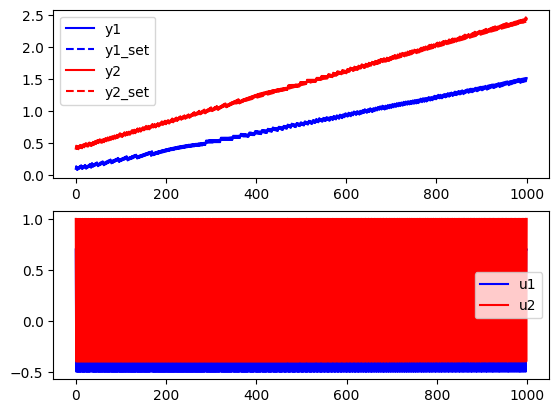

In [11]:
plt.subplot(2, 1, 1)
plt.plot(obs_array[:, 0], label='y1', color="b")
plt.plot(y1_setpoints, label='y1_set', color="b", linestyle='--')
plt.plot(obs_array[:, 1], label='y2', color="r")
plt.plot(y2_setpoints, label='y2_set', color="r", linestyle='--')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(act_array[:, 0], label='u1', color="b")
plt.plot(act_array[:, 1], label='u2', color="r")
plt.legend()

plt.show()

In [12]:
dummyEnv.close()